In [2]:
from collections import defaultdict
from glob import glob

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
import pandas as pd
import patsy
import re

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import QuantileTransformer

from sklearn.pipeline import make_pipeline

% matplotlib inline

NAN = float('nan')
INPUT_PATH = "data/2/{}_2014-2017.csv"
OUTPUT_FEATURES_PATH = "data/models/features/{}.csv"
OUTPUT_TARGET_PATH = "data/models/target/{}.csv"

pos = ["RB", "WR", "TE"]

def get_XY(features, position):
    df = pd.read_csv(INPUT_PATH.format(position))[features + ['next_fp']]
    df.dropna(inplace=True)
    y = df['next_fp']
    X = df.drop(columns=['next_fp'])
    return X, y

def get_XY_all(features):
    X_RB, y_RB = get_XY(features, "RB")
    X_RB['RB'] = 1
    X_RB['WR'] = 0
    X_WR, y_WR = get_XY(features, "WR")
    X_WR['RB'] = 0
    X_WR['WR'] = 1
    X = pd.concat([X_RB, X_WR])
    y = pd.concat([y_RB, y_WR])
    return X, y

def save_XY(X, y, key):
    xfile = OUTPUT_FEATURES_PATH.format(key)
    print("Writing to", xfile)
    X.to_csv(xfile)
    yfile = OUTPUT_TARGET_PATH.format(key)
    print("Writing to", yfile)
    y.to_csv(yfile)
    print("Done!")

/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Compile my features for my first model!
* Leave out TE, they seem to be a little different.
* Rush attempts and rush yards are likely to be collinear. Leave out rush yards for now. Maybe later we can use average yards per rush attempt (rush_yd/rush_att).
* Receiving stats all seem to be collinear, except for touchdowns actually achieved.

### Compare to my base model MSEs:

| Model  |  Train |  Test   |
|--------|:-------|:--------|
|mean   |40.127002492034535|50.004396566579906|
|median |40.127002492034535|50.00439656657992 |
|fp     |35.019148955600954|41.6004587105478  |


### TODO: Try the sklearn Imputer for NAN values.

In [790]:
features1 = ['week', 'nfc_n', 'nfc_w', 'nfc_s', 'nfc_e', 'afc_n', 'afc_s', 'afc_w',
             'rush_yd', 'rush_td', 'rush_att', 'rec_rec', 'rec_target', 'rec_yd', 'rec_td',
             'status_code', 'fp',
             'temperature', 'precipitation', 'wind', 'dome']

X, y = get_XY_all(features1)
save_XY(X, y, "RB_and_WR_1")
X.head()

Writing to data/models/features/RB_and_WR_1.csv
Writing to data/models/target/RB_and_WR_1.csv
Done!


,week,nfc_n,nfc_w,nfc_s,nfc_e,afc_n,afc_s,afc_w,rush_yd,rush_td,...,rec_yd,rec_td,status_code,fp,temperature,precipitation,wind,dome,RB,WR
0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,1.0,...,0.0,0.0,0.0,10.9,88,0.0,2,0.0,1,0
1,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,1.0,...,9.0,0.0,0.0,19.4,70,0.0,0,1.0,1,0
2,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,...,1.0,0.0,0.0,4.2,51,0.0,5,0.0,1,0
3,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,...,3.0,0.0,0.0,3.1,51,0.0,5,0.0,1,0
4,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,1.0,...,7.0,0.0,0.0,19.8,28,0.0,9,0.0,1,0


Start out with simple pipeline.

In [791]:

pipelines = [
    make_pipeline(LinearRegression()),
    make_pipeline(StandardScaler(), LinearRegression()),
    make_pipeline(Imputer(), StandardScaler(), LinearRegression())
]

def get_model_scores(X, y, reg, cv=10):
    # 10-fold cross-validation with our training data
    #reg = make_pipeline(pipeline)
    #reg = make_pipeline(Imputer(), StandardScaler(), LinearRegression())
    r2_scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print('-----------------------')
    print('Rˆ2 for each cross-val:',r2_scores,'\n')
    print('Mean Rˆ2 of all cross vals:',np.mean(r2_scores),'+-',np.std(r2_scores))

    mse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

    # scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
    print('Mean for each cross-val:',-mse_scores,'\n')
    print('Mean of all cross vals:',np.mean(-mse_scores),'+-',np.std(-mse_scores))
    print('-----------------------')
    return (r2_scores, np.std(r2_scores)), (-mse_scores, np.std(-mse_scores))

get_model_scores(X, y, pipelines[0]) # Just linear reg
get_model_scores(X, y, pipelines[1]) # normalize, linear reg
get_model_scores(X, y, pipelines[2]) # imputer, normalize, linear reg


-----------------------
Rˆ2 for each cross-val: [ 0.05475657  0.10779619  0.10703315  0.1237581   0.09683589  0.01419444
  0.04334319  0.01760975 -0.04164536 -0.01681487] 

Mean Rˆ2 of all cross vals: 0.050686704551948 +- 0.05429873501222398
Mean for each cross-val: [41.7813348  35.77005128 43.79151542 36.2218647  40.85205392 33.64507279
 32.02585133 36.37933552 25.38985576 25.72102107] 

Mean of all cross vals: 35.15779566022104 +- 5.919450943321948
-----------------------
-----------------------
Rˆ2 for each cross-val: [ 0.05475657  0.10779619  0.10703315  0.1237581   0.09683589  0.01419444
  0.04334319  0.01760975 -0.04164536 -0.01681487] 

Mean Rˆ2 of all cross vals: 0.050686704551948014 +- 0.05429873501222417
Mean for each cross-val: [41.7813348  35.77005128 43.79151542 36.2218647  40.85205392 33.64507279
 32.02585133 36.37933552 25.38985576 25.72102107] 

Mean of all cross vals: 35.15779566022104 +- 5.91945094332194
-----------------------
-----------------------
Rˆ2 for each cro

((array([ 0.05475657,  0.10779619,  0.10703315,  0.1237581 ,  0.09683589,
          0.01419444,  0.04334319,  0.01760975, -0.04164536, -0.01681487]),
  0.05429873501222417),
 (array([41.7813348 , 35.77005128, 43.79151542, 36.2218647 , 40.85205392,
         33.64507279, 32.02585133, 36.37933552, 25.38985576, 25.72102107]),
  5.91945094332194))

In [ ]:
# 10-fold cross-validation with our training data
reg = make_pipeline(Imputer(), StandardScaler(), LinearRegression())
r2_scores = cross_val_score(reg, X, y, cv=10, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',r2_scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(r2_scores),'+-',np.std(r2_scores))

mse_scores = cross_val_score(reg, X, y, cv=10, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Mean for each cross-val:',-mse_scores,'\n')
print('Mean of all cross vals:',np.mean(-mse_scores),'+-',np.std(-mse_scores))

### Check for correlations in normalized data.

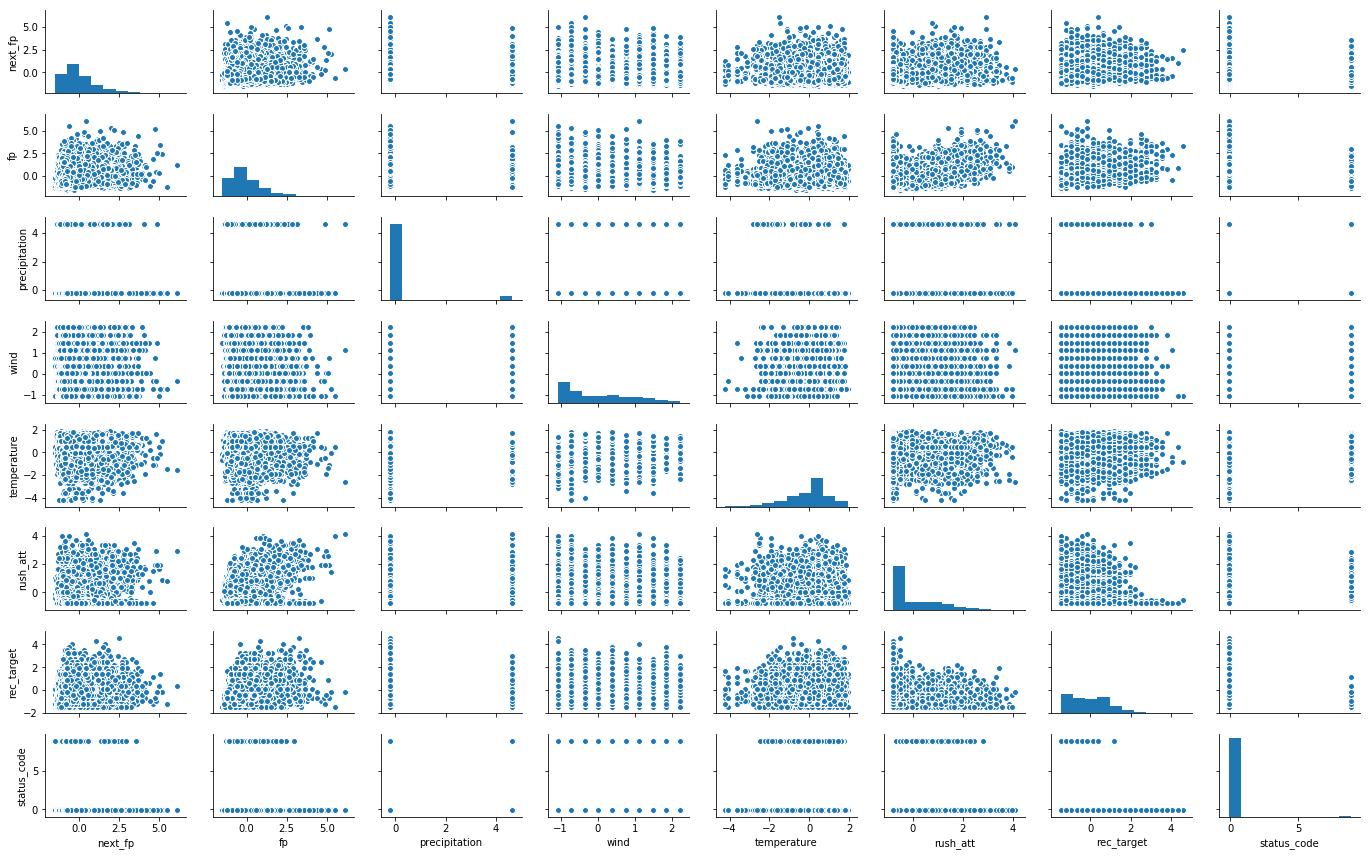

In [147]:
columns = ['next_fp', 'fp', 'precipitation', 'wind', 'temperature', 'rush_att', 'rec_target', 'status_code']
df = pd.concat([
    pd.read_csv(INPUT_PATH.format("RB"))[columns],
    pd.read_csv(INPUT_PATH.format("WR"))[columns]
])
df.dropna(inplace=True)

norm_data = StandardScaler().fit_transform(df.values)
norm_df = pd.DataFrame(norm_data, index=df.index, columns=df.columns)
sns.pairplot(norm_df, size=1.5, aspect=1.6)

## Try transforming.

### Lasso.

In [72]:
def PolynomialLasso(X, y, degrees, alpha):
    reg = LinearRegression()
    res_cv = {}
    res_train = {}
    for degree in degrees:

        print("Working on degree", degree)
    
        # transforms the data to polynomials
        est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
        #est = make_pipeline(Imputer(), PolynomialFeatures(degree), StandardScaler(), Lasso(alpha=alpha))
        est.fit(X, y)

        # calculates the MSE for CV
        scores = cross_val_score(est, X, y, cv=3, scoring='neg_mean_squared_error') # cross val
        res_cv[degree] = np.mean(-scores)
    
        # calculates the MSE for Training Set
        est.fit(X,y)
        y_pred = est.predict(X)
        res_train[degree] = np.sum((y_pred-y)**2)/len(y)
    return res_train, res_cv

def plot(res_train, res_cv):
    degrees = list(res_cv.keys())
    mse_cv = list(res_cv.values())
    mse_train = list(res_train.values())

    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    plt.plot(degrees,mse_cv)
    plt.plot(degrees,mse_train)
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('Normal Scale')
    plt.legend(['CV','Train'])

    plt.subplot(1,2,2)
    plt.semilogy(degrees,mse_cv)
    plt.semilogy(degrees,mse_train)
    plt.xlabel('Degree')
    plt.ylabel('MSE')
    plt.title('Log Scale')

    loc = np.argmin(list(res_cv.values()))
    print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])


Working on degree 1
Working on degree 2
The degree 2 had an MSE of: 35.09743627524841


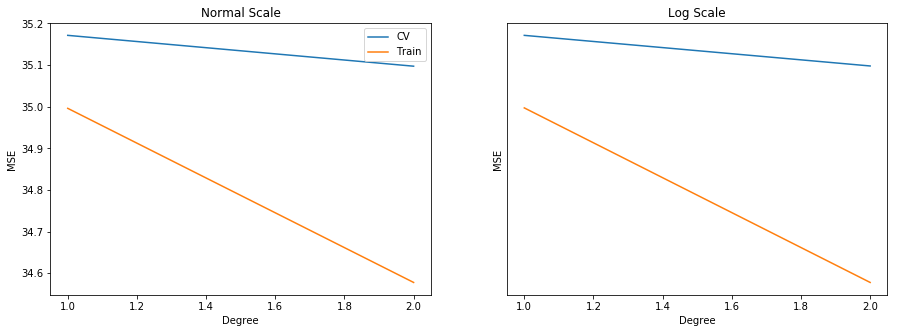

In [794]:
res_train, res_cv = PolynomialLasso(X, y, [1, 2], 0.1)
plot(res_train, res_cv)

### Ridge.

In [156]:
from sklearn.linear_model import RidgeCV

reg = LinearRegression()
res_cv = {}
res_train = {}
for degree in [0, 1, 2, 3]:
    print("Working on degree", degree)
    
    # transforms the data to polynomials
    est = make_pipeline(Imputer(), PolynomialFeatures(degree), StandardScaler(), Ridge(alpha=1))
    est.fit(X, y)

    # calculates the MSE for CV
    scores = cross_val_score(est, X, y, cv=3, scoring='neg_mean_squared_error') # cross val
    res_cv[degree] = np.mean(-scores)
    
    # calculates the MSE for Training Set
    est.fit(X,y)
    y_pred = est.predict(X)
    res_train[degree] = np.sum((y_pred-y)**2)/len(y)

Working on degree 0
Working on degree 1
Working on degree 2
Working on degree 3


The degree 1 had an MSE of: 35.43906597841901


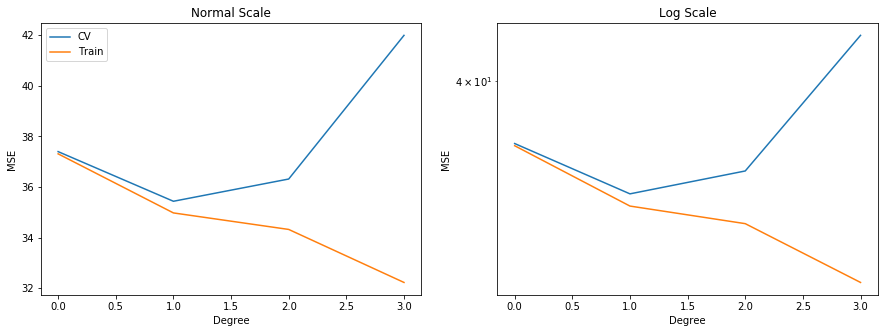

In [157]:
degrees = list(res_cv.keys())
mse_cv = list(res_cv.values())
mse_train = list(res_train.values())

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.plot(degrees,mse_cv)
plt.plot(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Normal Scale')
plt.legend(['CV','Train'])

plt.subplot(1,2,2)
plt.semilogy(degrees,mse_cv)
plt.semilogy(degrees,mse_train)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Log Scale')

# Get the smallest MSE, which are saved in res_cv
loc = np.argmin(list(res_cv.values()))
print('The degree',degrees[loc],'had an MSE of:',mse_cv[loc])

Make some more models...

next_fp ~ np.exp(fp)(nfc_n + nfc_s + afc_w + afc_s + status_code)(rush_yd)(rush_att)(rush_td) + (rec_yd)(rec_target)(rec_rec)(rec_td)


In [45]:
# Base
features = ['nfc_w', 'afc_s',
             'rush_att', 'rush_td', 'rush_yd', 'rec_target', 'rec_rec', 'rec_td', 'rec_yd',
            'status_code', 'fp', 'week',
             'temperature', 'precipitation', 'wind', 'dome']

def get_df(features):
    RB = pd.read_csv(INPUT_PATH.format("RB"))[features + ['next_fp']]
    #RB['RB'] = 1
    RB['WR'] = 0
    WR = pd.read_csv(INPUT_PATH.format("WR"))[features + ['next_fp']]
    #WR['RB'] = 0
    WR['WR'] = 1
    return pd.concat([RB, WR])

model1 = get_df(features)
master_df = model1.copy(deep=True)


In [21]:
# Modify
X = model1
X['yd_rec'] = np.divide(X['rec_yd'], np.exp(X['rec_rec']))
X['yd_att'] = np.divide(X['rush_yd'], np.exp(X['rush_att']))
X['td_yd'] = np.divide(X['rush_td'], np.exp(X['rush_yd']))
X['td_att'] = np.divide(X['rush_td'], np.exp(X['rush_att']))
#X['rec_success'] = np.divide(X['rec_rec'], np.exp(X['rec_target']))
#X['sq_td'] = np.square(X['rec_td'])
#X['exp_nfc_e'] = np.exp(X['nfc_e'])
#X['exp_nfc_w'] = np.exp(X['nfc_w'])
#X['exp_nfc_n'] = np.exp(X['nfc_n'])
#X['exp_nfc_s'] = np.exp(X['nfc_s'])
#X['exp_afc_w'] = np.exp(X['afc_w'])
#X['exp_afc_s'] = np.exp(X['afc_s'])
#X['exp_afc_n'] = np.exp(X['afc_n'])
X.head()

,nfc_w,afc_s,rush_att,rush_td,rush_yd,rec_target,rec_rec,rec_td,rec_yd,status_code,...,precipitation,wind,dome,next_fp,RB,WR,yd_rec,yd_att,td_yd,td_att
0,0.0,0.0,13.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,0.0,19.4,1,0,0.000000,1.107561e-04,5.242886e-22,2.260329e-06
1,0.0,0.0,19.0,1.0,125.0,1.0,1.0,0.0,9.0,0.0,...,0.0,0,1.0,4.2,1,0,3.310915,7.003496e-07,5.166421e-55,5.602796e-09
2,0.0,0.0,13.0,0.0,41.0,4.0,1.0,0.0,1.0,0.0,...,0.0,5,0.0,19.8,1,0,0.367879,9.267351e-05,0.000000e+00,0.000000e+00
3,0.0,0.0,10.0,0.0,28.0,3.0,1.0,0.0,3.0,0.0,...,0.0,5,0.0,5.1,1,0,1.103638,1.271198e-03,0.000000e+00,0.000000e+00
4,0.0,0.0,17.0,1.0,131.0,5.0,3.0,0.0,7.0,0.0,...,0.0,9,0.0,8.0,1,0,0.348509,5.423318e-06,1.280628e-57,4.139938e-08


### Check P-values

In [10]:
def check_P(df, features=None, transformed_features=None):
    if transformed_features is None:
        transformed_features = make_R(features)
    y, X = patsy.dmatrices(transformed_features, data = df, return_type="dataframe")
    model = sm.OLS(y, X)
    fit = model.fit()
    return fit.summary()
    
def make_R(features):
    formula = 'next_fp ~'
    for f in features:
        formula += f + "+"
    return formula[:-1]

In [56]:
#subset_all = ['afc_s','rush_att', 'rec_target', 'rec_rec', 'rec_yd','status_code', 'fp', 'temperature', 'wind', 'WR', 'RB']

# R^2 0.074
subset = ['status_code', 'week', 'afc_s', 'rush_att', 'rec_target', 'fp', 'rec_td', 'temperature', 'wind', 'WR']
check_P(X, features=subset)
#        transformed_features="next_fp ~ np.exp(status_code) + week + np.exp(afc_s) + rush_att + rec_target + np.exp(rec_td) + fp + temperature + wind + np.exp(WR)")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                next_fp   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     51.36
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          7.96e-100
Time:                        23:05:22   Log-Likelihood:                -20254.
No. Observations:                6341   AIC:                         4.053e+04
Df Residuals:                    6330   BIC:                         4.060e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       7.4244      0.490     15.143      0.000       6.463       8.386
status_code    -0.4310      0.326     -1.324      0.186      -1.069       0.207
week           -0.0373      0.018     -2.120      0.034      -0.072      -0.003
afc_s          -0.3334      0.231     -1.446      0.148      -0.785       0.119
rush_att        0.2215      0.018     12.315      0.000       0.186       0.257
rec_target      0.1986      0.026      7.644      0.000       0.148       0.249
fp              0.1037      0.018      5.630      0.000       0.068       0.140
rec_td         -0.3671      0.188     -1.950      0.051      -0.736       0.002
temperature    -0.0137      0.005     -2.502      0.012      -0.025      -0.003
wind           -0.0397      0.027     -1.444      0.149      -0.094       0.014
WR              2.3185      0.260      8.925      0.000       1.809       2.828
==============================================================================
Omnibus:                     1315.279   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2617.957
Skew:                           1.243   Prob(JB):                         0.00
Kurtosis:                       4.930   Cond. No.                         437.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

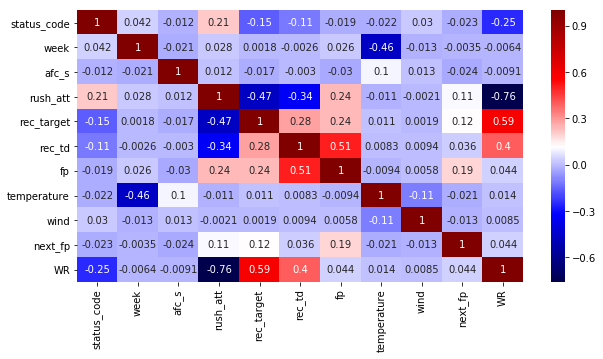

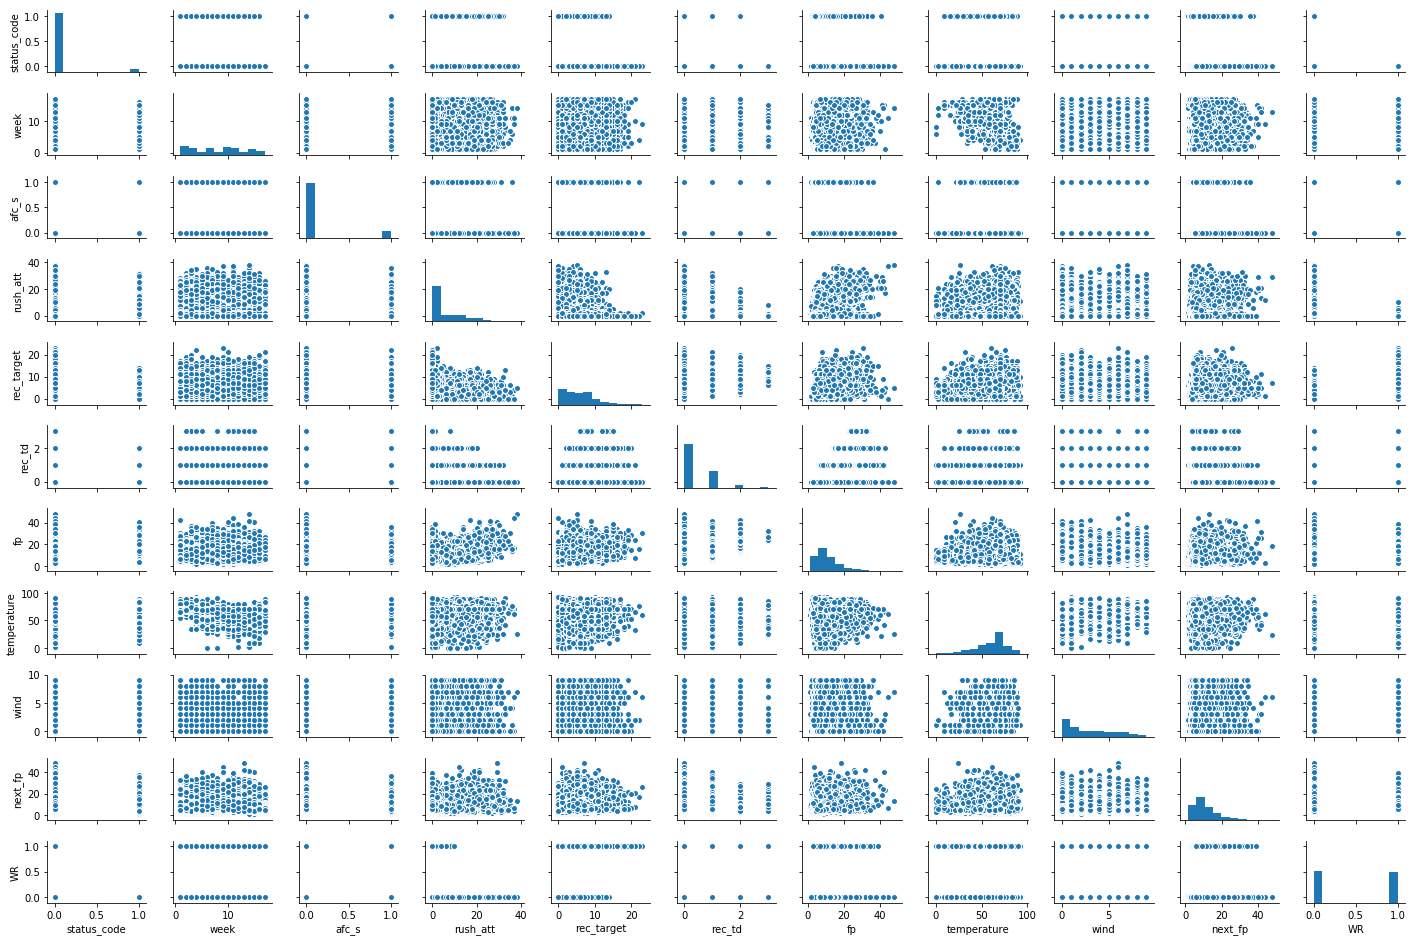

In [48]:
subset = ['status_code', 'week', 'afc_s', 'rush_att', 'rec_target', 'rec_td', 'fp','temperature', 'wind']
X = get_df(subset)

def show_corr(df):
    fig, ax = plt.subplots(figsize=(10,5), ncols=1, nrows=1)
    
    sns.pairplot(df, size=1.2, aspect=1.5)
    sns.heatmap(df.corr(), cmap="seismic", annot=True, ax=ax)

show_corr(X)

In [691]:
subset = ['rush_att', 'rush_yd', 'rec_target', 'precipitation', 'fp', 'afc_s', 'wind']
# ---
# TE only
# subset = ['rec_target', 'rec_yd', 'rec_rec', 'yd_rec', 'precipitation']
# 19.714
# ---------
# RB only
# subset = ['rush_att', 'afc_s', 'rec_target', 'precipitation', 'fp']
# 39.24
# subset = ['rush_att', 'rush_yd', 'rush_td', 'rec_target', 'rec_yd','dome', 'precipitation', 'temperature', 'status_code', 'afc_s']
# The degree 2 had an MSE of: 39.69414808242065
# all columns
# The degree 2 had an MSE of: 39.75724996271267
# ---------
# WR + RB
# subset = ['rush_att', 'rush_yd', 'rush_td', 'rec_target', 'rec_rec', 'rec_yd', 'rec_td', 'wind', 'afc_s']
# The degree 2 had an MSE of: 35.234800927891925
# subset = ['rush_att', 'rush_yd', 'rush_td', 'rec_target', 'rec_rec', 'rec_yd', 'rec_td', 'wind', 'sq_temp', 'status_code', 'afc_s']
# The degree 2 had an MSE of: 35.232596356512495
# subset = ['afc_s', 'afc_n', 'status_code', 'rush_att', 'rush_yd', 'rec_target', 'rec_rec', 'rec_yd', 'fp', 'precipitation', 'wind']
# 35.3516
# subset = ['rush_att', 'rush_yd', 'rec_target', 'rec_rec', 'rec_yd', 'fp', 'wind']
# 35.3662
#X[subset + ['next_fp']].corr()

check_P(features=subset)

# Apply regression and plot residuals

Working on degree 0
Working on degree 4
Working on degree 5
Working on degree 6
The degree 4 had an MSE of: 37.19337152763534


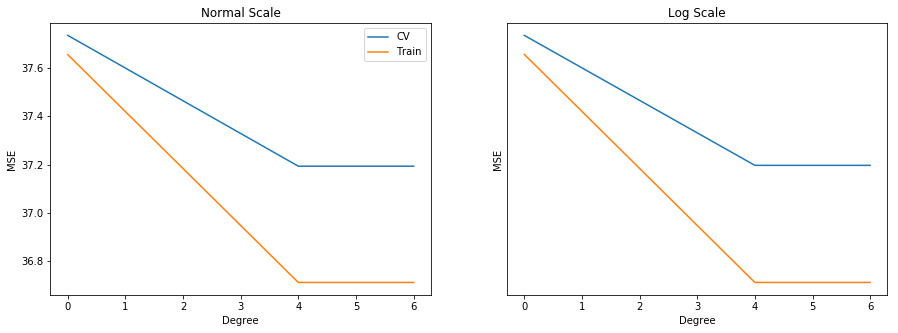

In [71]:
X1 = X[subset]
y1 = X['next_fp']
res_train, res_cv = PolynomialLasso(X1, y1, [0, 4, 5, 6], alpha=0.8)
plot(res_train, res_cv)

* res_train, res_cv = PolynomialLasso(X1, y1, [1, 2, 3], alpha=1) = 35.18 w/out StandardScaler
* res_train, res_cv = PolynomialLasso(X1, y1, [1, 3, 4], alpha=0.1) = 35.16 w/ StandardScaler
* res_train, res_cv = PolynomialLasso(X1, y1, [0, 4, 5], alpha=0.8) = 37.193 w/ StandardScaler


# Save model

In [58]:
save_XY(X1, y1, key="WR_dummy_0")

Writing to data/models/features/WR_dummy_0.csv
Writing to data/models/target/WR_dummy_0.csv
Done!


***subset = ['rush_att', 'rush_yd', 'rush_td', 'rec_target', 'rec_rec', 'rec_yd', 'rec_td', 'wind', 'afc_s']
alpha = 0.1***

# Results
* TE: rec_target, rec_yd, rec_rec, precipitation, yd/rec ~ 19.71 deg 5
* WR: rec_target, precipitation, rec_yd, rec_rec, dome, nfc_w ~ 30.12 deg 5
* RB: 